<a href="https://colab.research.google.com/github/sivaneswari102/advanced-time-series-attention-lstm/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset (example: stock prices)
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')
data.columns = ['date', 'value']

data.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['value'] = scaler.fit_transform(data[['value']])

# Create sequences
def create_sequences(series, time_steps=10):
    X, y = [], []
    for i in range(len(series) - time_steps):
        X.append(series[i:i+time_steps])
        y.append(series[i+time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 10
X, y = create_sequences(data['value'].values, TIME_STEPS)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_lr_train = X_train.reshape(X_train.shape[0], -1)
X_lr_test = X_test.reshape(X_test.shape[0], -1)

lr = LinearRegression()
lr.fit(X_lr_train, y_train)

lr_pred = lr.predict(X_lr_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
print('Linear Regression RMSE:', lr_rmse)

Linear Regression RMSE: 0.11816727309244833


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential([
    LSTM(64, input_shape=(TIME_STEPS, 1)),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

lstm_pred = lstm_model.predict(X_test)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
print('LSTM RMSE:', lstm_rmse)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0596 - val_loss: 0.1405
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0245 - val_loss: 0.0487
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0065 - val_loss: 0.0128
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0094 - val_loss: 0.0106
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0078 - val_loss: 0.0170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
LSTM RMSE: 0.18702965931794144


In [14]:
from tensorflow.keras.layers import Input, Multiply, Softmax, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

inputs = Input(shape=(TIME_STEPS, 1))
lstm_out = LSTM(64, return_sequences=True)(inputs)

attention = Dense(1, activation='tanh')(lstm_out)
attention = Softmax(axis=1)(attention)

context = Multiply()([lstm_out, attention])
context = Lambda(lambda x: tf.reduce_sum(x, axis=1))(context)

output = Dense(1)(context)

att_model = Model(inputs, output)
att_model.compile(optimizer='adam', loss='mse')
att_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

att_pred = att_model.predict(X_test)
att_rmse = np.sqrt(mean_squared_error(y_test, att_pred))
print('Attention LSTM RMSE:', att_rmse)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.0429 - val_loss: 0.1475
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0226 - val_loss: 0.0824
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0118 - val_loss: 0.0335
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0060 - val_loss: 0.0151
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0080 - val_loss: 0.0164
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step
Attention LSTM RMSE: 0.19031843056151726


In [15]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'LSTM', 'Attention LSTM'],
    'RMSE': [lr_rmse, lstm_rmse, att_rmse]
})

results


,Model,RMSE
0,Linear Regression,0.118167
1,LSTM,0.187030
2,Attention LSTM,0.190318


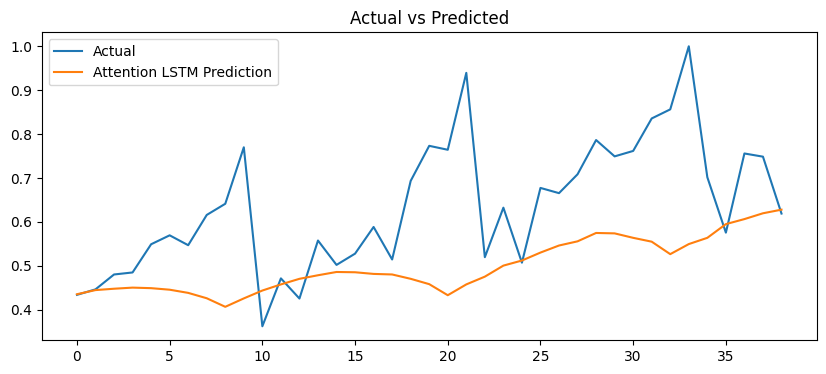

In [16]:
plt.figure(figsize=(10,4))
plt.plot(y_test, label='Actual')
plt.plot(att_pred, label='Attention LSTM Prediction')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()